In [73]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV

In [2]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# @title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
# @title Data loading

dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


# Exploring data

In [5]:
negative_spike_count = np.sum(np.any(dat['sresp'] < 0, axis=1))
print(negative_spike_count)


2


In [6]:
i_neurons = [0, 321]
i_print = slice(0,10)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    dat['sresp'][i].dtype,
    dat['sresp'][i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 2.9820833  8.409119  12.720393   0.         0.         7.274833
 18.580465   3.79022    3.4137561  3.1182032]


Neuron 321:
float32
[ 9.140973  0.        1.862105  0.       16.781614 16.269245 15.841542
  0.       40.110836  0.      ]




sresp basically has 11983 neurons, and 7018 timebins for each neuron. So in each timebin, we see the neuron spike response. Each timebin is consecutive for 1.2s so the spike response is sequential

In [12]:
print("Max:",np.max(dat['sresp']),"\nMin:",np.min(dat['sresp']),"\nMean: ",np.mean(dat['sresp']),"\nMedian: ",np.median(dat['sresp']))

Max: 2417.7021 
Min: -5.6768604e-06 
Mean:  39.823532 
Median:  15.809069


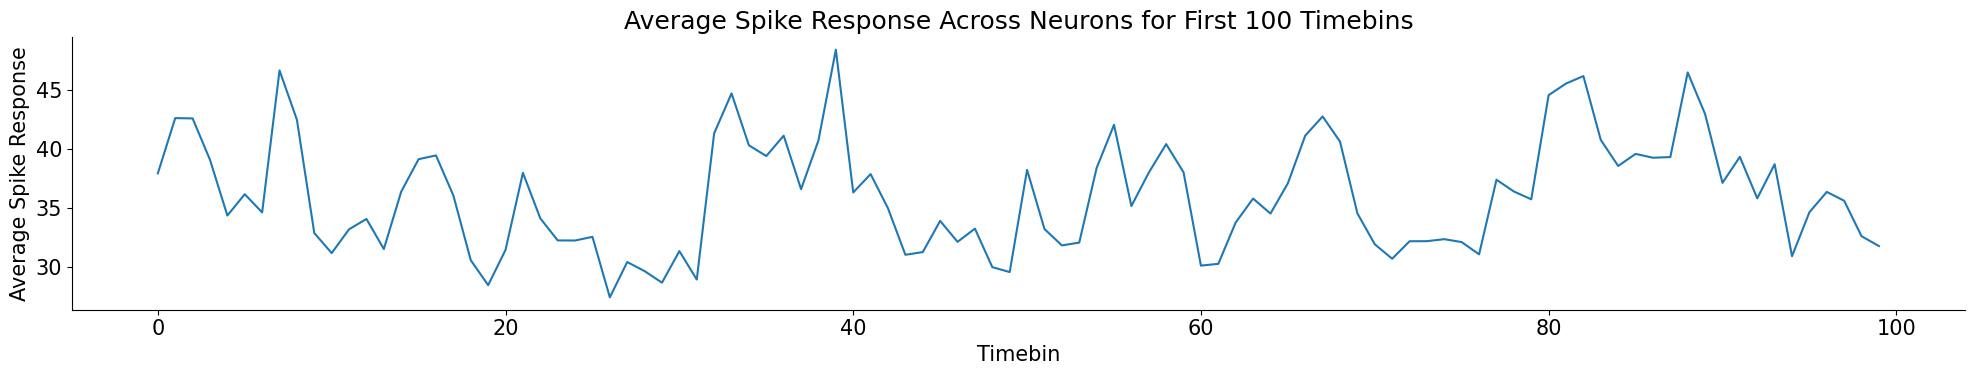

In [13]:
# Average spike response across all neurons for the first few timebins
avg_spike_response = np.mean(dat['sresp'][:, :100], axis=0)

plt.plot(avg_spike_response)
plt.xlabel('Timebin')
plt.ylabel('Average Spike Response')
plt.title('Average Spike Response Across Neurons for First 100 Timebins')
plt.show()


6.8859396 4.776567


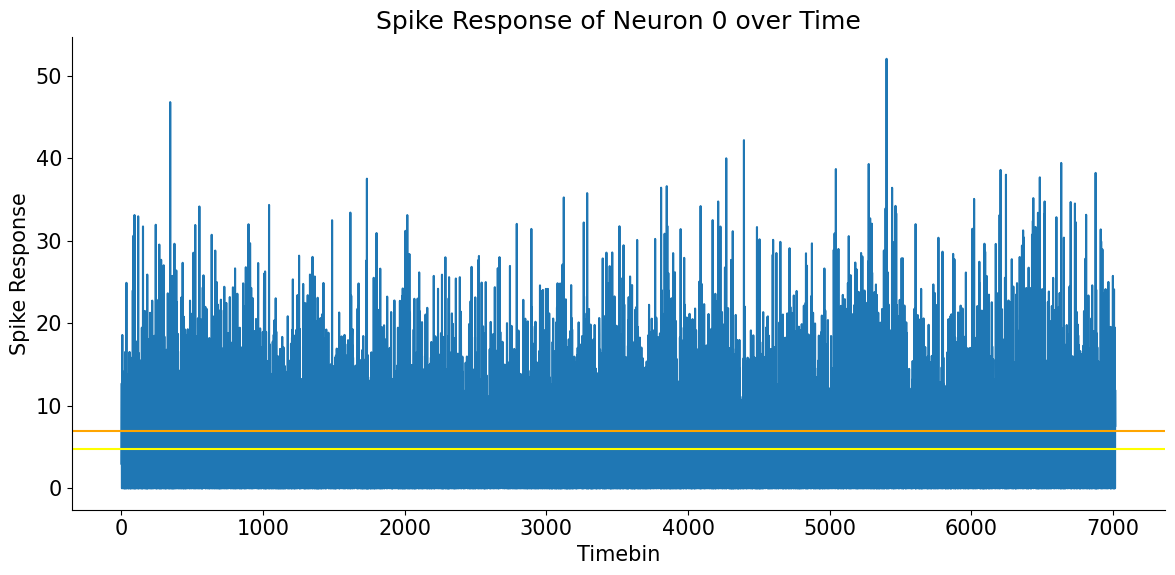

In [14]:
timebins = np.arange(7018)
mean_spike_resp = np.mean(dat['sresp'][0])
median_spike_resp = np.median(dat['sresp'][0])
print(mean_spike_resp, median_spike_resp)
plt.figure(figsize=(12, 6))
plt.plot(timebins, dat['sresp'][0])
plt.axhline(mean_spike_resp, color="orange", label="Mean neuron")
plt.axhline(median_spike_resp, color="yellow", label="Median neuron")
plt.xlabel('Timebin')
plt.ylabel('Spike Response')
plt.title('Spike Response of Neuron 0 over Time')
plt.show()

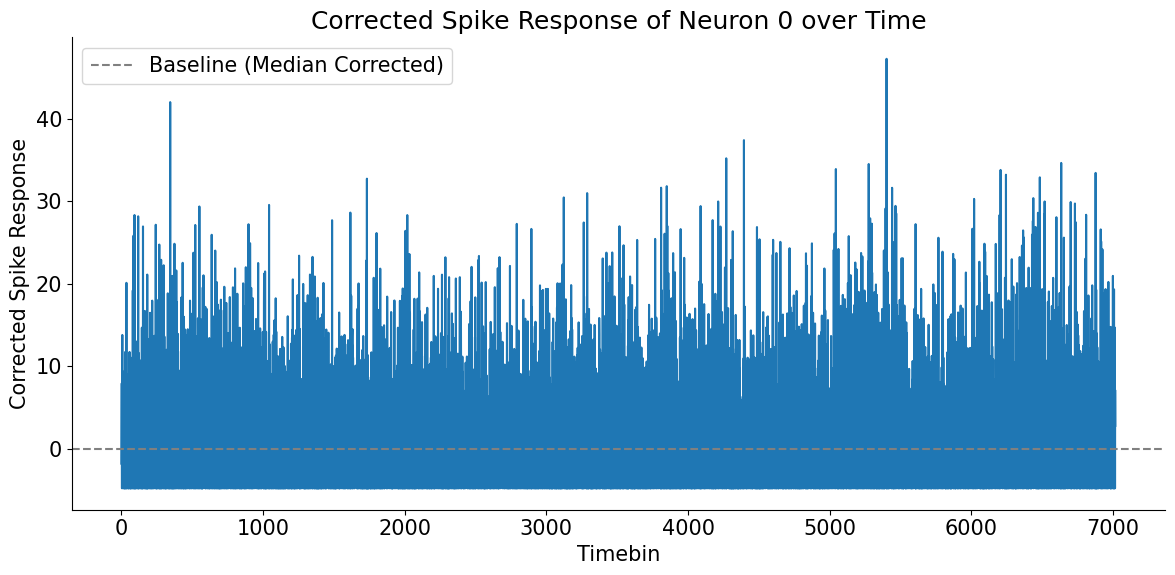

In [15]:
# Baseline correction by subtracting the median
baseline_corrected_resp = dat['sresp'][0] - median_spike_resp

# Plot the corrected spike response
plt.figure(figsize=(12, 6))
plt.plot(timebins, baseline_corrected_resp)
plt.axhline(0, color="gray", linestyle="--", label="Baseline (Median Corrected)")
plt.xlabel('Timebin')
plt.ylabel('Corrected Spike Response')
plt.title('Corrected Spike Response of Neuron 0 over Time')
plt.legend()
plt.show()


15.088903427124023


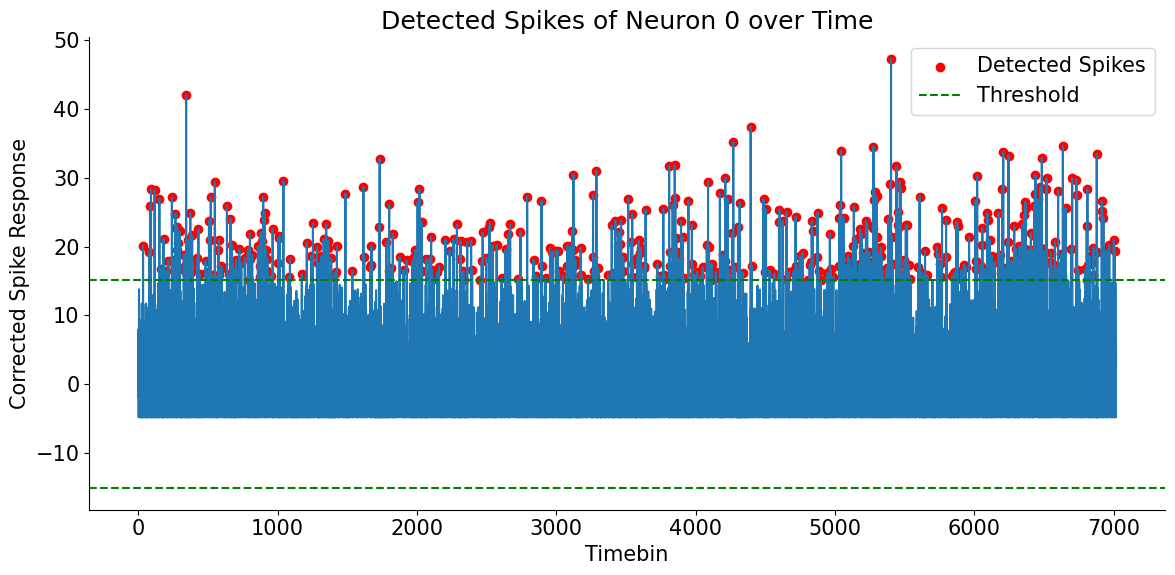

In [16]:
# Calculate standard deviation of the baseline-corrected data
std_spike_resp = np.std(baseline_corrected_resp)

# Define the new threshold (e.g., 2 times the standard deviation)
new_threshold = 2 * std_spike_resp
print(new_threshold)

# Detect spikes
spike_times = np.where(baseline_corrected_resp > new_threshold)[0]

# Plot detected spikes
plt.figure(figsize=(12, 6))
plt.plot(timebins, baseline_corrected_resp)
plt.scatter(spike_times, baseline_corrected_resp[spike_times], color='red', label='Detected Spikes')
plt.axhline(new_threshold, color="green", linestyle="--", label="Threshold")
plt.axhline(-new_threshold, color="green", linestyle="--")
plt.xlabel('Timebin')
plt.ylabel('Corrected Spike Response')
plt.title('Detected Spikes of Neuron 0 over Time')
plt.legend()
plt.show()


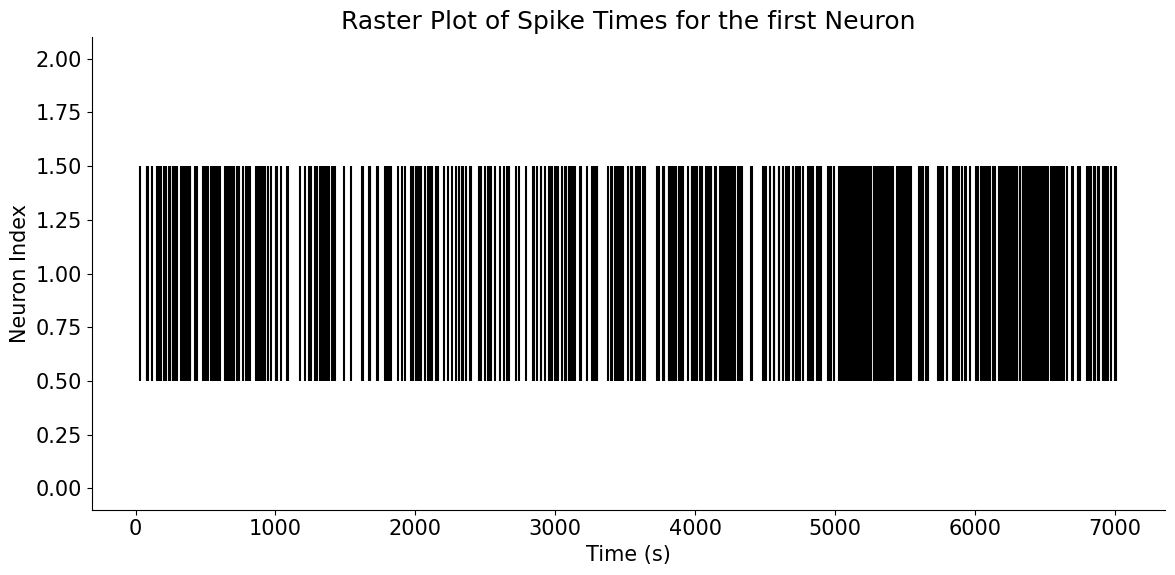

In [17]:
import numpy as np
import matplotlib.pyplot as plt
# Plot the raster plot
plt.figure(figsize=(12, 6))
plt.eventplot(spike_times, color='black')
plt.xlabel("Time (s)")
plt.ylabel("Neuron Index")
plt.title("Raster Plot of Spike Times for the first Neuron")
plt.show()


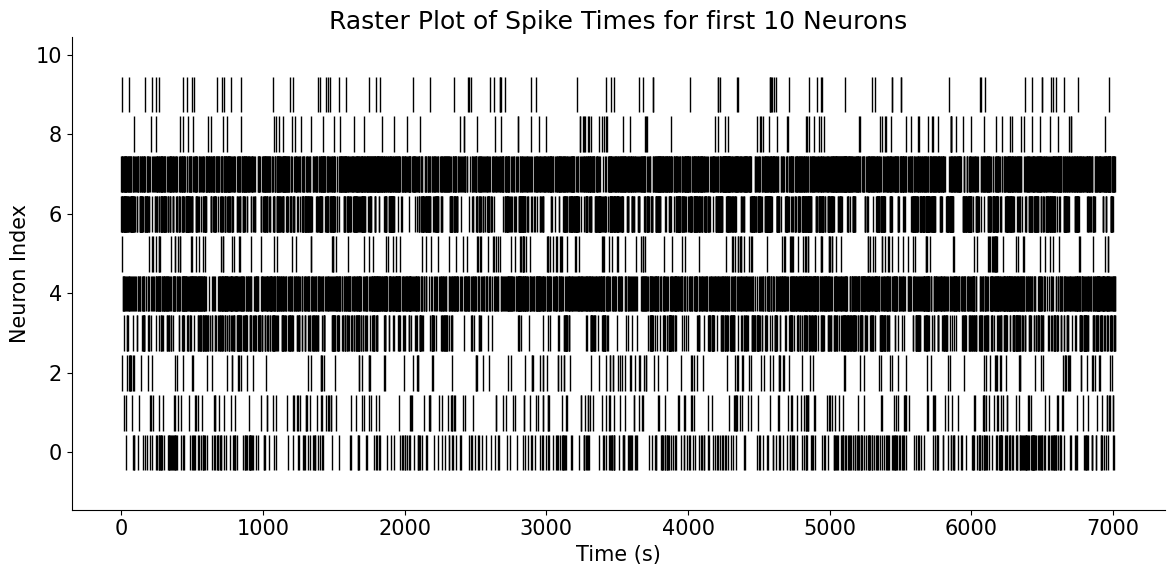

In [18]:
import numpy as np
import matplotlib.pyplot as plt
spikes=[]
for i in range(10):
    neuron_idx = i
    baseline_corrected_resp = dat['sresp'][neuron_idx] - np.median(dat['sresp'][neuron_idx])
    spike_times = np.where(baseline_corrected_resp > new_threshold)[0]
    spikes.append(spike_times)
offsets = np.arange(10)


# Plot the raster plot
plt.figure(figsize=(12, 6))
plt.eventplot(spikes, color='black', linewidth=1, lineoffsets=offsets, linelengths=0.9)
plt.xlabel("Time (s)")
plt.ylabel("Neuron Index")
plt.title("Raster Plot of Spike Times for first 10 Neurons")
plt.show()


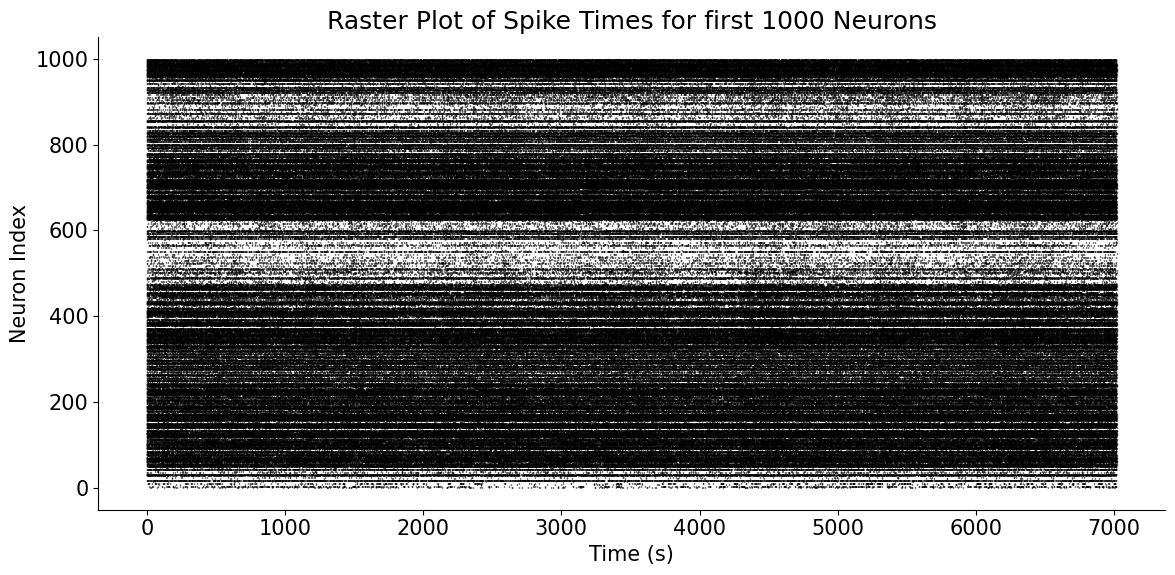

In [19]:
import numpy as np
import matplotlib.pyplot as plt
spikes=[]
for i in range(1000):
    neuron_idx = i
    baseline_corrected_resp = dat['sresp'][neuron_idx] - np.median(dat['sresp'][neuron_idx])
    spike_times = np.where(baseline_corrected_resp > new_threshold)[0]
    spikes.append(spike_times)
offsets = np.arange(1000)


# Plot the raster plot
plt.figure(figsize=(12, 6))
plt.eventplot(spikes, color='black', linewidth=1, lineoffsets=offsets, linelengths=0.9)
plt.xlabel("Time (s)")
plt.ylabel("Neuron Index")
plt.title("Raster Plot of Spike Times for first 1000 Neurons")
plt.show()


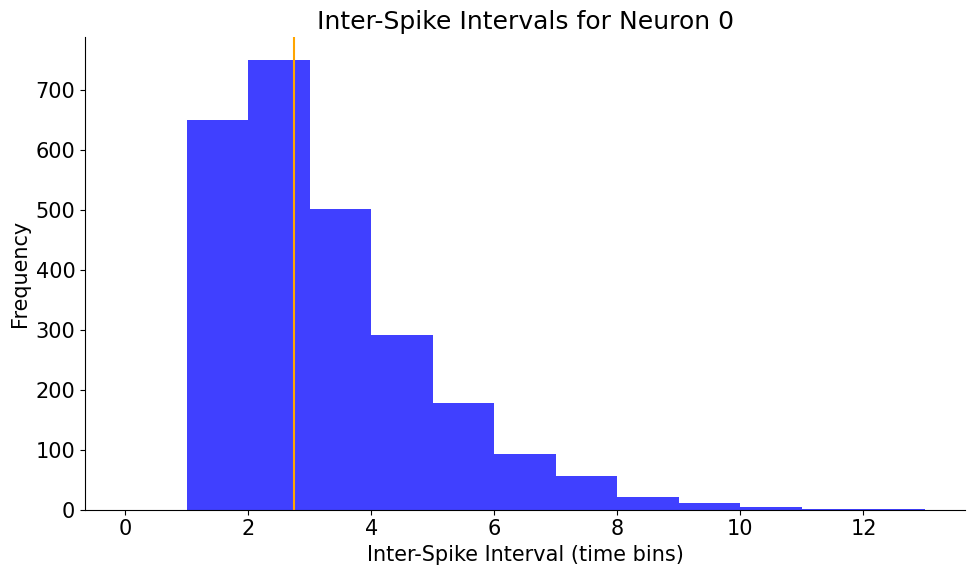

In [20]:
# Calculate inter-spike intervals (ISIs)
isis = np.diff(spike_times)

# Plot ISIs
plt.figure(figsize=(10, 6))
plt.hist(isis, bins=np.arange(0, np.max(isis) + 1, 1), alpha=0.75, color='blue')
plt.axvline(isis.mean(), color="orange", label="Mean ISI")
plt.xlabel('Inter-Spike Interval (time bins)')
plt.ylabel('Frequency')
plt.title('Inter-Spike Intervals for Neuron 0')
plt.show()

C:\Users\adith\AppData\Local\Temp\ipykernel_27200\2919665611.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


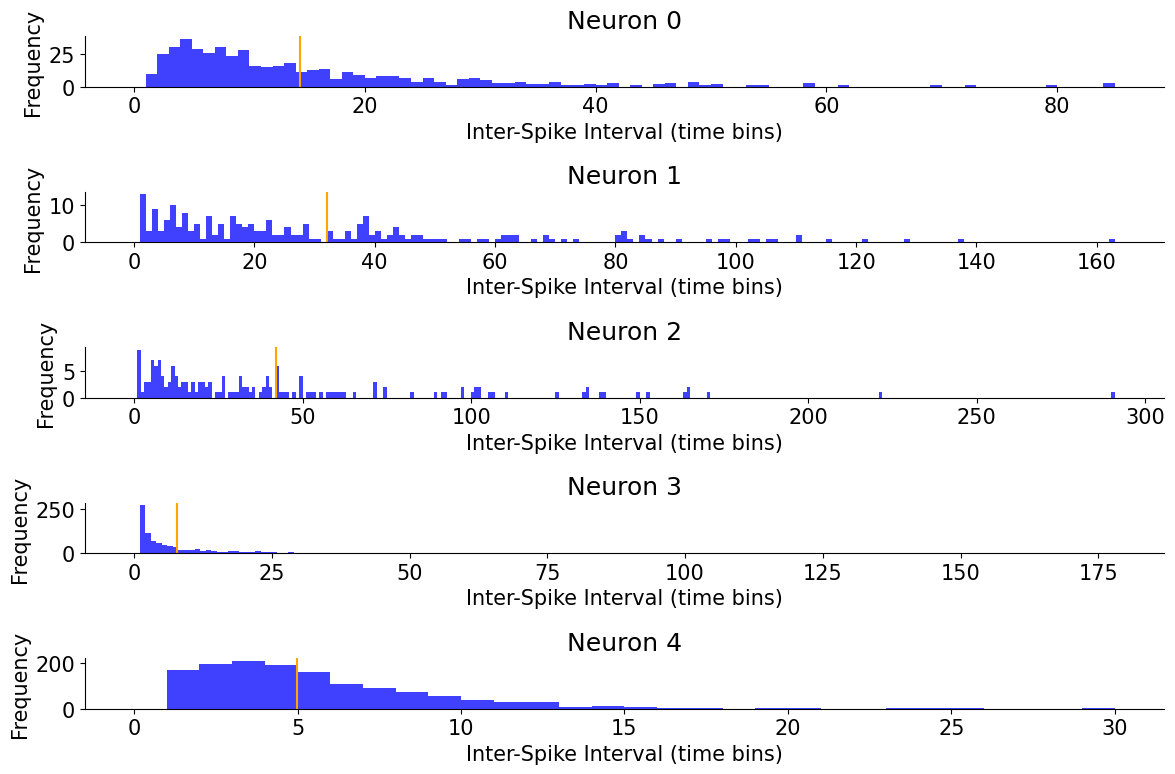

In [21]:
num_neurons = 5  # Number of neurons to analyze
plt.figure(figsize=(12, 8))

for i in range(num_neurons):
    neuron_idx = i
    baseline_corrected_resp = dat['sresp'][neuron_idx] - np.median(dat['sresp'][neuron_idx])
    spike_times = np.where(baseline_corrected_resp > new_threshold)[0]
    isis = np.diff(spike_times)

    plt.subplot(num_neurons, 1, i + 1)
    plt.hist(isis, bins=np.arange(0, np.max(isis) + 1, 1), alpha=0.75, color='blue')
    plt.xlabel('Inter-Spike Interval (time bins)')
    plt.axvline(isis.mean(), color="orange", label="Mean ISI")
    plt.ylabel('Frequency')
    plt.title(f'Neuron {neuron_idx}')
    plt.tight_layout()

plt.show()


In [23]:
import numpy as np

# Compute average firing rate across all neurons for each time bin
avg_firing_rate = np.mean(dat['sresp'], axis=0)

# Define thresholds for high and low firing activity
high_firing_threshold = np.percentile(avg_firing_rate, 75)  # Top 25% as high firing
low_firing_threshold = np.percentile(avg_firing_rate, 25)   # Bottom 25% as low firing

# Identify time bins with high and low firing activity
high_firing_bins = avg_firing_rate >= high_firing_threshold
low_firing_bins = avg_firing_rate <= low_firing_threshold

# Extract pupil area and running speed
pupil_area = dat['pupilArea']
running_speed = dat['run']

# Extract data for high and low firing periods
high_firing_pupil_area = pupil_area[high_firing_bins]
low_firing_pupil_area = pupil_area[low_firing_bins]
high_firing_running_speed = running_speed[high_firing_bins]
low_firing_running_speed = running_speed[low_firing_bins]


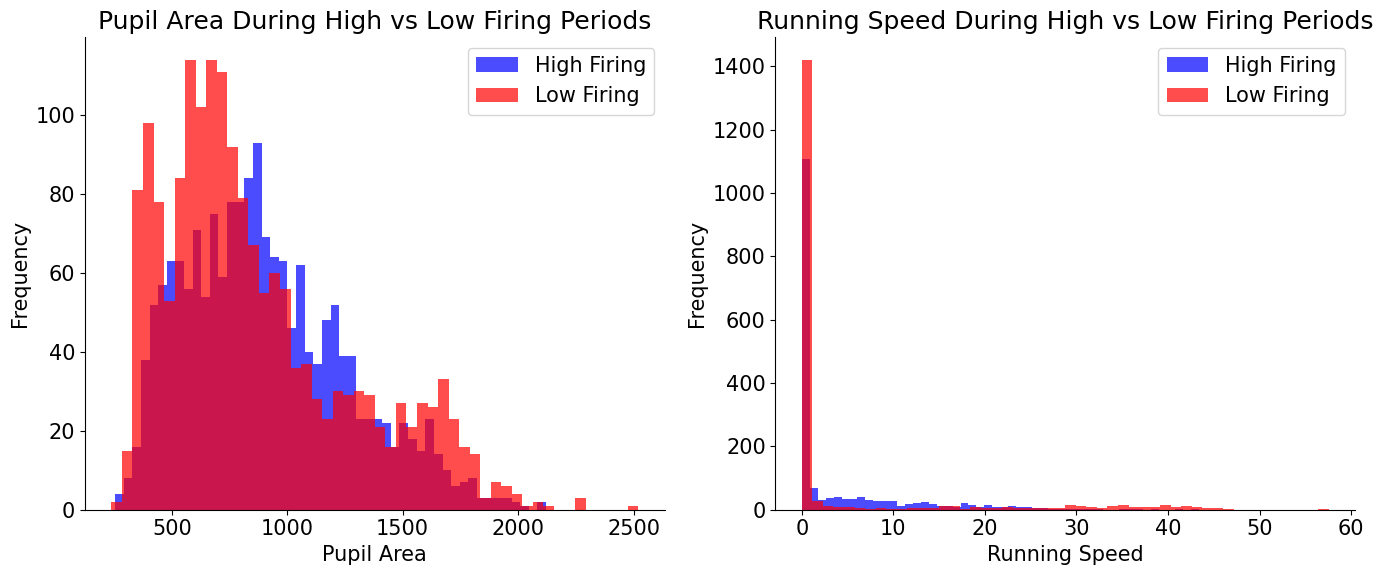

In [24]:
import matplotlib.pyplot as plt

# Plot Pupil Area
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(high_firing_pupil_area, bins=50, alpha=0.7, color='blue', label='High Firing')
plt.hist(low_firing_pupil_area, bins=50, alpha=0.7, color='red', label='Low Firing')
plt.xlabel('Pupil Area')
plt.ylabel('Frequency')
plt.title('Pupil Area During High vs Low Firing Periods')
plt.legend()

# Plot Running Speed
plt.subplot(1, 2, 2)
plt.hist(high_firing_running_speed, bins=50, alpha=0.7, color='blue', label='High Firing')
plt.hist(low_firing_running_speed, bins=50, alpha=0.7, color='red', label='Low Firing')
plt.xlabel('Running Speed')
plt.ylabel('Frequency')
plt.title('Running Speed During High vs Low Firing Periods')
plt.legend()

plt.tight_layout()
plt.show()


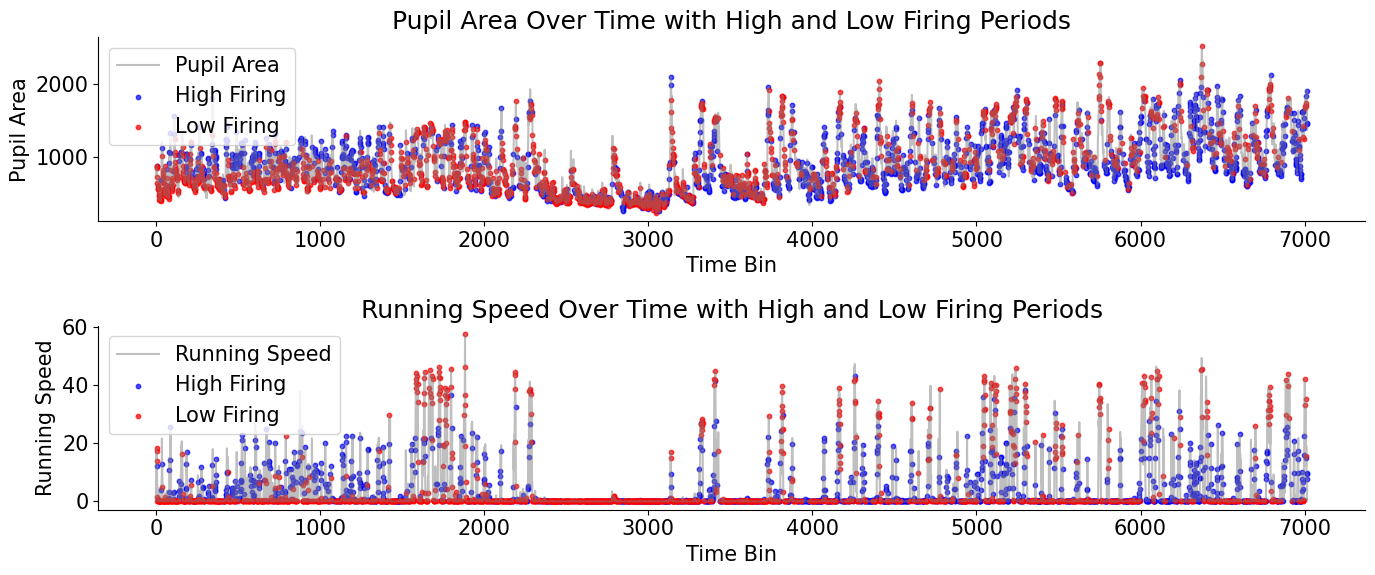

In [25]:
# Plot Time Series Data
plt.figure(figsize=(14, 6))

# Pupil Area
plt.subplot(2, 1, 1)
plt.plot(dat['pupilArea'], label='Pupil Area', color='gray', alpha=0.5)
plt.scatter(np.where(high_firing_bins)[0], dat['pupilArea'][high_firing_bins], color='blue', label='High Firing', alpha=0.7, s=10)
plt.scatter(np.where(low_firing_bins)[0], dat['pupilArea'][low_firing_bins], color='red', label='Low Firing', alpha=0.7, s=10)
plt.xlabel('Time Bin')
plt.ylabel('Pupil Area')
plt.title('Pupil Area Over Time with High and Low Firing Periods')
plt.legend()

# Running Speed
plt.subplot(2, 1, 2)
plt.plot(dat['run'], label='Running Speed', color='gray', alpha=0.5)
plt.scatter(np.where(high_firing_bins)[0], dat['run'][high_firing_bins], color='blue', label='High Firing', alpha=0.7, s=10)
plt.scatter(np.where(low_firing_bins)[0], dat['run'][low_firing_bins], color='red', label='Low Firing', alpha=0.7, s=10)
plt.xlabel('Time Bin')
plt.ylabel('Running Speed')
plt.title('Running Speed Over Time with High and Low Firing Periods')
plt.legend()

plt.tight_layout()
plt.show()


# PCA

In [28]:
import numpy as np
import pandas as pd

sresp = dat['sresp']  # Neural response data: (11983 neurons x 7018 timebins)
pupilArea = dat['pupilArea']  # Pupil area data: (7018,)
run = dat['run']  # Running speed data: (7018,)
# Mean-center the neural response data
sresp_mean_centered = sresp - np.mean(sresp, axis=1, keepdims=True)


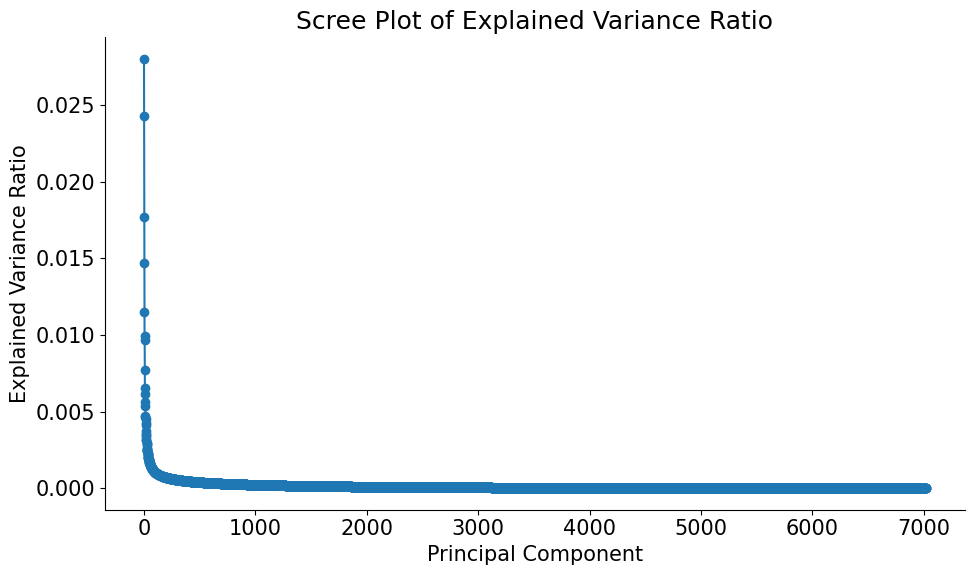

In [29]:
pca = PCA()
principal_components = pca.fit_transform(sresp_mean_centered.T)
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot of Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()


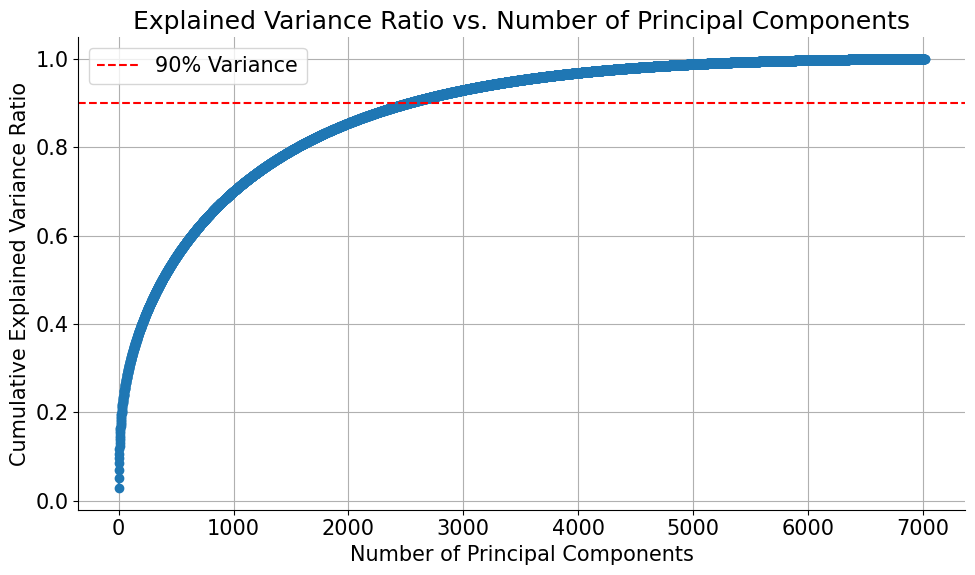

In [30]:
import matplotlib.pyplot as plt

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Principal Components')
plt.axhline(0.90, color='red', linestyle='--', label='90% Variance')
plt.legend()
plt.grid()
plt.show()


In [32]:
# Find number of components to explain at least 90% variance
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_cumulative = np.cumsum(explained_variance_ratio)
num_components_for_90_variance = np.argmax(explained_variance_cumulative >= 0.90) + 1
print(f'Number of principal components to explain at least 90% variance: {num_components_for_90_variance}')


Number of principal components to explain at least 90% variance: 2526


In [33]:
num_pcs = 2526
pca = PCA(n_components=num_pcs)
reduced_data = pca.fit_transform(sresp_mean_centered.T)  # (7018 timebins x 2526 PCs)

# Flatten the 2D arrays to 1D
pupilArea_flattened = pupilArea.flatten()  # Shape (7018,)
run_flattened = run.flatten()  # Shape (7018,)
num_pcs_to_use = 3
principal_components_to_use = reduced_data[:, :num_pcs_to_use]


# Check the shapes to ensure they are 1D
print(f'pupilArea_flattened.shape: {pupilArea_flattened.shape}')
print(f'run_flattened.shape: {run_flattened.shape}')


pupilArea_flattened.shape: (7018,)
run_flattened.shape: (7018,)


In [34]:
# Create a DataFrame for visualization and analysis
data_for_regression = pd.DataFrame({
    'Pupil Area': pupilArea_flattened,
    'Running Speed': run_flattened,
    'Principal Component 1': principal_components_to_use[:, 0],
    'Principal Component 2': principal_components_to_use[:, 1],
    'Principal Component 3': principal_components_to_use[:, 2],  # Add more PCs if needed
})

# Check the DataFrame
print(data_for_regression.head())


   Pupil Area  Running Speed  Principal Component 1  Principal Component 2  \
0  833.333895       0.043625            -814.789551             770.032166   
1  745.139269       5.688507             843.124756            1967.033081   
2  838.572260       9.130915             694.729309            1296.547607   
3  836.409290      16.939346             532.657166            1084.760620   
4  843.813529      17.465670            1101.997070            -103.417915   

   Principal Component 3  
0             163.206497  
1             200.508163  
2             398.176666  
3             784.997375  
4              93.789055  


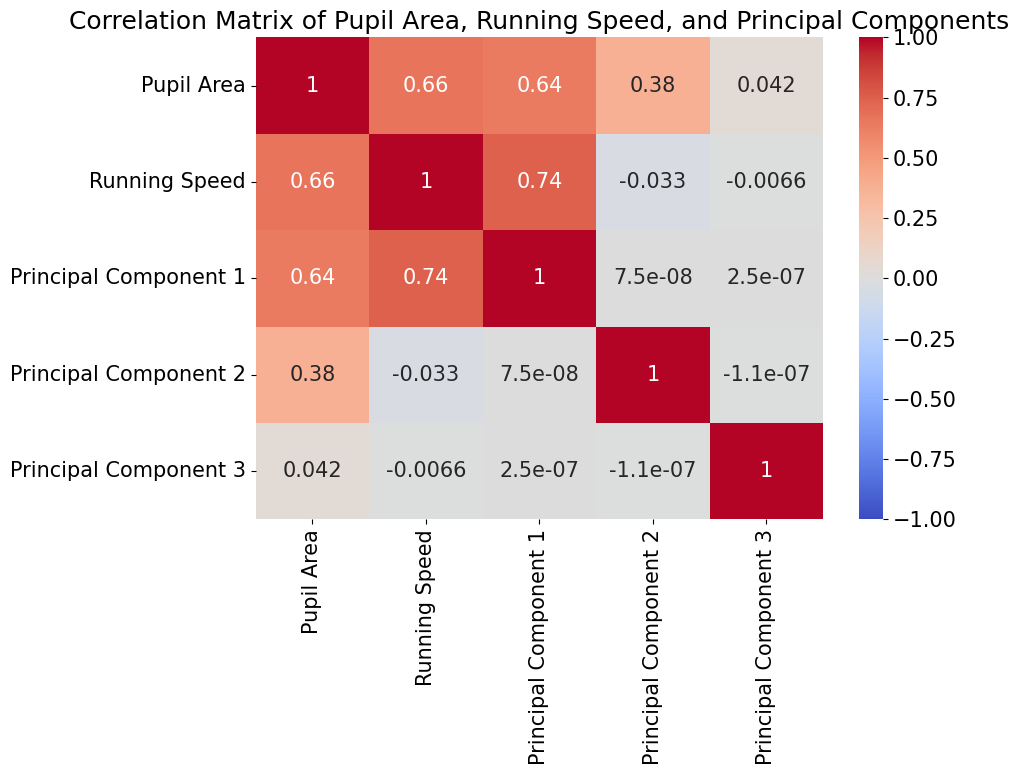

In [35]:
# Correlation Matrix
correlation_matrix = data_for_regression.corr()

# Plot Heatmap of Correlation Matrix
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Pupil Area, Running Speed, and Principal Components')
plt.show()


# Predictions

## Just Raw Data without any PCA

In [51]:
# Data Preparation
X = dat['sresp'].T  # Transpose to get shape (timebins, neurons)
y = dat['pupilArea'].flatten()

# Split the data 
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
        X, y, np.arange(X.shape[0]), test_size=0.2, random_state=42)

## Ridge

In [44]:
# Define alpha range for RidgeCV
alphas = np.logspace(-6, 6, 13)

# Ridge Regression with cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

# Predict on test set
y_pred = ridge_cv.predict(X_test)
y_ridge=y_pred

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Ridge Regression without PCA:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {ridge_cv.alpha_}')

Ridge Regression without PCA:
Mean Squared Error: 27127.85
R^2 Score: 0.80
Best Alpha: 1000000.0


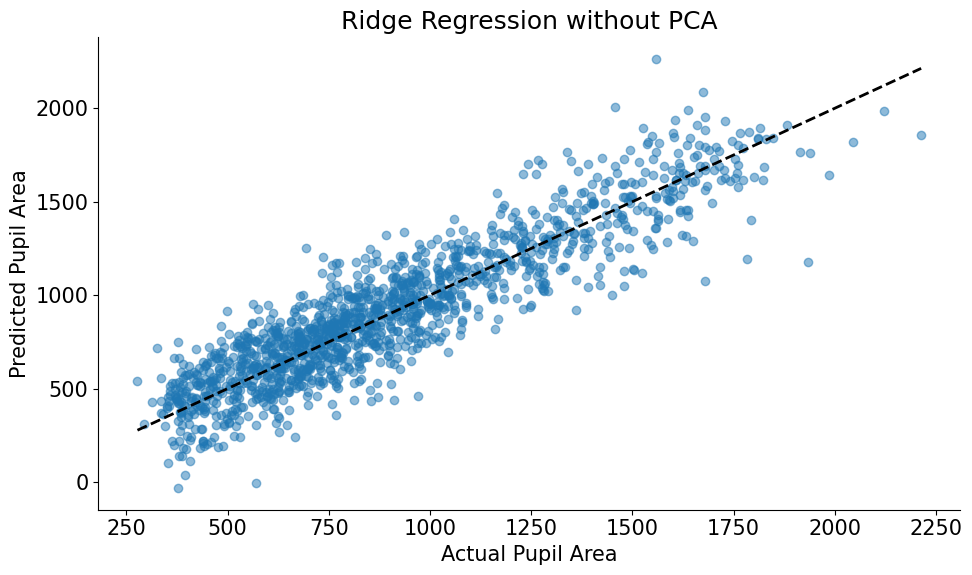

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Ridge Regression without PCA')
plt.show()

## Lasso

C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.611e+05, tolerance: 6.285e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e+05, tolerance: 6.285e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.764e+05, toleranc

Lasso Regression without PCA:
Mean Squared Error: 15332.55
R^2 Score: 0.89
Best Alpha: 100.0


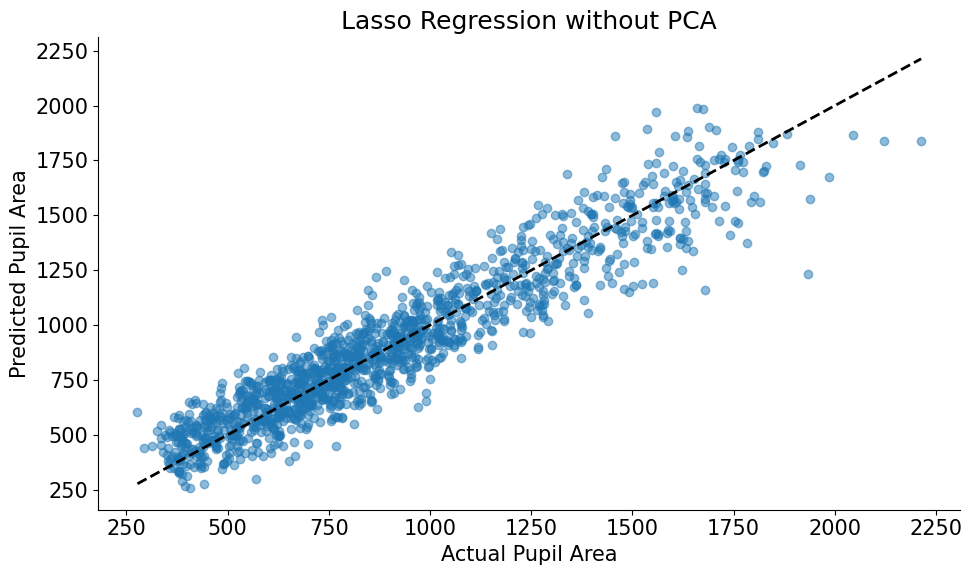

In [67]:
from sklearn.linear_model import LassoCV

# Lasso Regression with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

# Predict on test set
y_pred = lasso_cv.predict(X_test)
y_lasso = y_pred

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Lasso Regression without PCA:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {lasso_cv.alpha_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Lasso Regression without PCA')
plt.show()


## ElasticNet

C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.432e+06, tolerance: 6.285e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e+05, tolerance: 6.285e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.298e+05, toleranc

C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.169e+05, tolerance: 6.285e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e+05, tolerance: 6.285e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e+05, toleranc

C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.407e+05, tolerance: 6.345e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e+05, tolerance: 6.345e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.334e+05, toleranc

C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e+05, tolerance: 6.243e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.419e+05, tolerance: 6.243e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.861e+05, toleranc

ElasticNet without PCA:
Mean Squared Error: 14961.37
R^2 Score: 0.89
Best Alpha: 1000.0, Best L1 ratio: 0.1


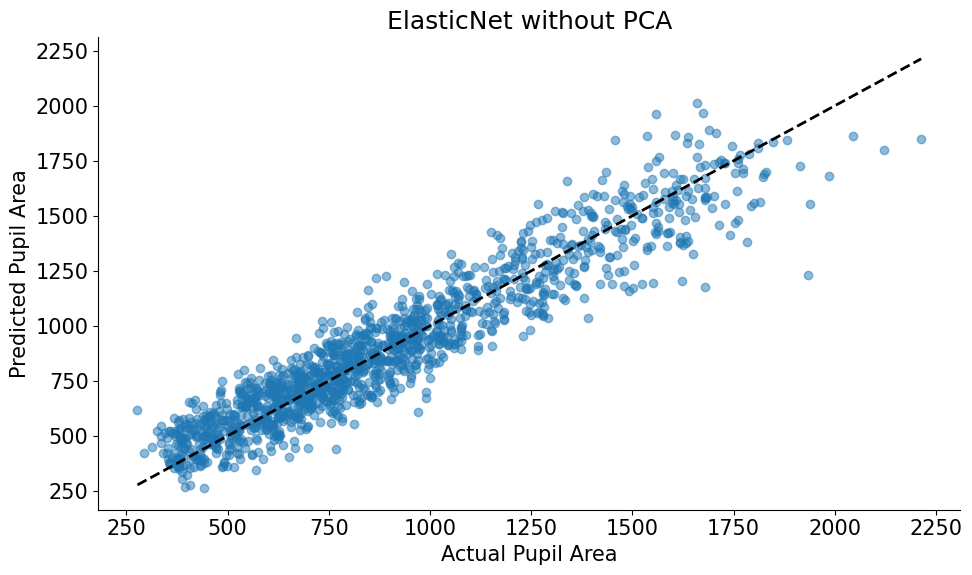

In [69]:
from sklearn.linear_model import ElasticNetCV

# ElasticNet with cross-validation
elasticnet_cv = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5)
elasticnet_cv.fit(X_train, y_train)

# Predict on test set
y_pred = elasticnet_cv.predict(X_test)
y_elastic = y_pred
# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'ElasticNet without PCA:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Alpha: {elasticnet_cv.alpha_}, Best L1 ratio: {elasticnet_cv.l1_ratio_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('ElasticNet without PCA')
plt.show()


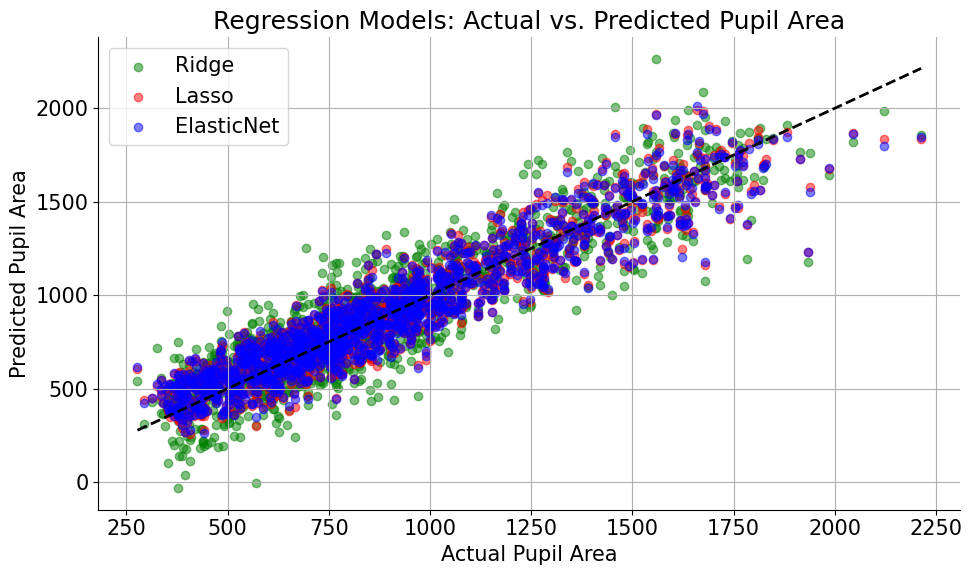

In [79]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_ridge, color='green', alpha=0.5, label='Ridge')
plt.scatter(y_test, y_lasso, color='red', alpha=0.5, label='Lasso')
plt.scatter(y_test, y_elastic, color='blue', alpha=0.5, label='ElasticNet')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Regression Models: Actual vs. Predicted Pupil Area')
plt.legend()
plt.grid(True)
plt.show()

Ridge Regression: Ridge regression adds a penalty equal to the sum of the squared values of the coefficients. This penalty shrinks the coefficients towards zero, but it doesn't set any of them exactly to zero.

Lasso Regression: Lasso regression adds a penalty equal to the sum of the absolute values of the coefficients. This penalty can shrink some coefficients to exactly zero, thus performing feature selection.

ElasticNet Regression: ElasticNet combines both the L1 and L2 penalties of the Lasso and Ridge methods. The parameter r determines the balance between the Lasso and Ridge penalty terms. When r=0, ElasticNet is equivalent to Ridge Regression, and when r=1, it is equivalent to Lasso Regression. We try to find an r that fits our data [some mix between ridge and lasso]

In [ ]:
# Todo [Make graphs to look at trends]
# 1. High and low firing neurons in each of these models 
# 2. High and low pupil area in each of these
# 3. Is there any relation between these?

## Same models on first 3 PCs

In [40]:
from sklearn.decomposition import PCA

# PCA Transformation
pca = PCA(n_components=3)  # Adjust number of components as needed
X_pca = pca.fit_transform(X)


# Split the PCA-transformed data
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [65]:
# Ridge Regression with cross-validation on PCA-transformed data
ridge_cv_pca = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv_pca.fit(X_train_pca, y_train_pca)

# Predict on test set
y_pred_pca = ridge_cv_pca.predict(X_test_pca)
y_ridge_pca=y_pred_pca

# Evaluate performance
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'Ridge Regression with PCA:')
print(f'Mean Squared Error: {mse_pca:.2f}')
print(f'R^2 Score: {r2_pca:.2f}')
print(f'Best Alpha: {ridge_cv_pca.alpha_}')


Ridge Regression with PCA:
Mean Squared Error: 59283.73
R^2 Score: 0.56
Best Alpha: 1000000.0


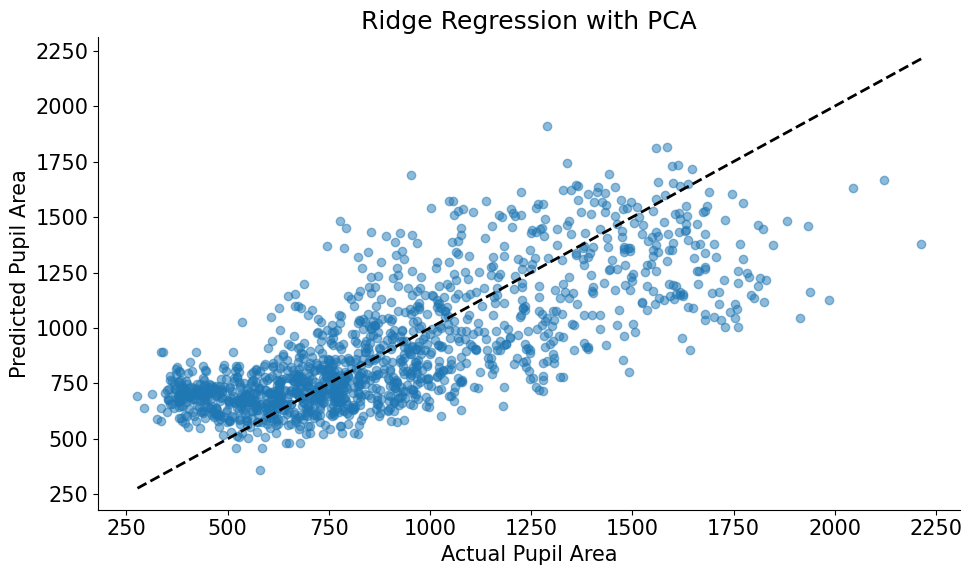

In [66]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pca, y_pred_pca, alpha=0.5)
plt.plot([y_test_pca.min(), y_test_pca.max()], [y_test_pca.min(), y_test_pca.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Ridge Regression with PCA')
plt.show()

C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2154549.75, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12701066.0, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27464790.0, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective di

Lasso Regression with PCA:
Mean Squared Error: 59281.66
R^2 Score: 0.56
Best Alpha: 100.0


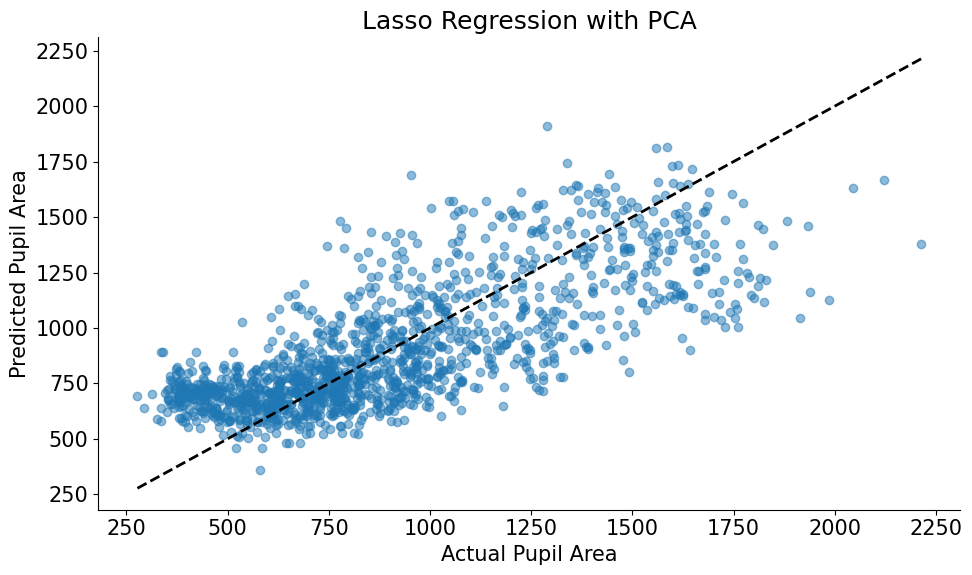

In [68]:
# Lasso Regression with cross-validation on PCA-transformed data
lasso_cv_pca = LassoCV(alphas=alphas, cv=5)
lasso_cv_pca.fit(X_train_pca, y_train_pca)

# Predict on test set
y_pred_pca = lasso_cv_pca.predict(X_test_pca)
y_lasso_pca = y_pred_pca
# Evaluate performance
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'Lasso Regression with PCA:')
print(f'Mean Squared Error: {mse_pca:.2f}')
print(f'R^2 Score: {r2_pca:.2f}')
print(f'Best Alpha: {lasso_cv_pca.alpha_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pca, y_pred_pca, alpha=0.5)
plt.plot([y_test_pca.min(), y_test_pca.max()], [y_test_pca.min(), y_test_pca.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Lasso Regression with PCA')
plt.show()


C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29914580.0, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21549100.0, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18168502.0, tolerance: 62850.83984375
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\adith\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective di

ElasticNet with PCA:
Mean Squared Error: 59280.20
R^2 Score: 0.56
Best Alpha: 1000.0, Best L1 ratio: 0.1


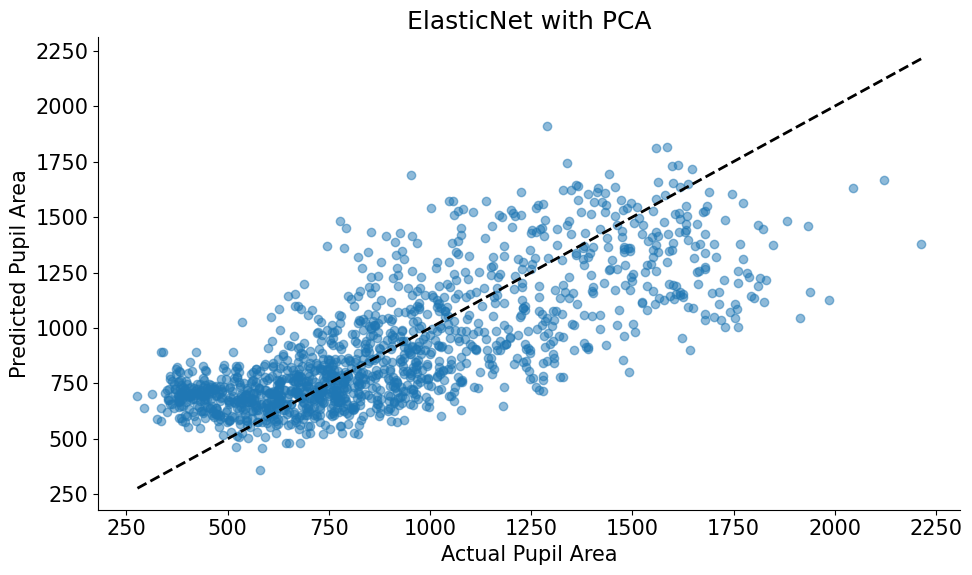

In [70]:
# ElasticNet with cross-validation on PCA-transformed data
elasticnet_cv_pca = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5)
elasticnet_cv_pca.fit(X_train_pca, y_train_pca)

# Predict on test set
y_pred_pca = elasticnet_cv_pca.predict(X_test_pca)
y_elastic_pca = y_pred_pca
# Evaluate performance
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'ElasticNet with PCA:')
print(f'Mean Squared Error: {mse_pca:.2f}')
print(f'R^2 Score: {r2_pca:.2f}')
print(f'Best Alpha: {elasticnet_cv_pca.alpha_}, Best L1 ratio: {elasticnet_cv_pca.l1_ratio_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pca, y_pred_pca, alpha=0.5)
plt.plot([y_test_pca.min(), y_test_pca.max()], [y_test_pca.min(), y_test_pca.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('ElasticNet with PCA')
plt.show()


## Some non linear models

In [74]:
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Perform grid search
rf_model = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2')
grid_search_rf.fit(X_train, y_train)

# Best model
best_rf = grid_search_rf.best_estimator_

# Predict on test set
y_pred = best_rf.predict(X_test)
y_rf = y_pred
# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Random Forest Regression without PCA:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Parameters: {grid_search_rf.best_params_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Random Forest Regression without PCA')
plt.show()


KeyboardInterrupt: 

In [ ]:
# Random Forest with PCA-transformed data
grid_search_rf_pca = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2')
grid_search_rf_pca.fit(X_train_pca, y_train_pca)

# Best model
best_rf_pca = grid_search_rf_pca.best_estimator_

# Predict on test set
y_pred_pca = best_rf_pca.predict(X_test_pca)
y_rf_pca = y_pred_pca
# Evaluate performance
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'Random Forest Regression with PCA:')
print(f'Mean Squared Error: {mse_pca:.2f}')
print(f'R^2 Score: {r2_pca:.2f}')
print(f'Best Parameters: {grid_search_rf_pca.best_params_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pca, y_pred_pca, alpha=0.5)
plt.plot([y_test_pca.min(), y_test_pca.max()], [y_test_pca.min(), y_test_pca.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('Random Forest Regression with PCA')
plt.show()


In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Convert the data into DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'alpha': [0, 0.1, 1],
    'lambda': [0, 0.1, 1]
}

# Perform grid search
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_

# Predict on test set
y_pred = best_xgb.predict(X_test)
y_xgb = y_pred
# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'XGBoost Regression without PCA:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Parameters: {grid_search.best_params_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('XGBoost Regression without PCA')
plt.show()


In [ ]:
# XGBoost with PCA-transformed data
X_train_pca_dmatrix = xgb.DMatrix(X_train_pca, label=y_train_pca)
X_test_pca_dmatrix = xgb.DMatrix(X_test_pca, label=y_test_pca)

# Perform grid search
grid_search_pca = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='r2')
grid_search_pca.fit(X_train_pca, y_train_pca)

# Best model
best_xgb_pca = grid_search_pca.best_estimator_

# Predict on test set
y_pred_pca = best_xgb_pca.predict(X_test_pca)
y_xgb_pca = y_pred_pca
# Evaluate performance
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'XGBoost Regression with PCA:')
print(f'Mean Squared Error: {mse_pca:.2f}')
print(f'R^2 Score: {r2_pca:.2f}')
print(f'Best Parameters: {grid_search_pca.best_params_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pca, y_pred_pca, alpha=0.5)
plt.plot([y_test_pca.min(), y_test_pca.max()], [y_test_pca.min(), y_test_pca.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('XGBoost Regression with PCA')
plt.show()


In [ ]:
import lightgbm as lgb

# Convert the data into LightGBM Dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameter grid
param_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20]
}

# Perform grid search
lgb_model = lgb.LGBMRegressor()
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, cv=5, scoring='r2')
grid_search_lgb.fit(X_train, y_train)

# Best model
best_lgb = grid_search_lgb.best_estimator_

# Predict on test set
y_pred = best_lgb.predict(X_test)
y_lgb = y_pred
# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'LightGBM Regression without PCA:')
print(f'Mean Squared Error: {mse:.2f}')
print(f'R^2 Score: {r2:.2f}')
print(f'Best Parameters: {grid_search_lgb.best_params_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('LightGBM Regression without PCA')
plt.show()


In [ ]:
# LightGBM with PCA-transformed data
grid_search_lgb_pca = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, cv=5, scoring='r2')
grid_search_lgb_pca.fit(X_train_pca, y_train_pca)

# Best model
best_lgb_pca = grid_search_lgb_pca.best_estimator_

# Predict on test set
y_pred_pca = best_lgb_pca.predict(X_test_pca)
y_lgb_pca= y_pred_pca
# Evaluate performance
mse_pca = mean_squared_error(y_test_pca, y_pred_pca)
r2_pca = r2_score(y_test_pca, y_pred_pca)

print(f'LightGBM Regression with PCA:')
print(f'Mean Squared Error: {mse_pca:.2f}')
print(f'R^2 Score: {r2_pca:.2f}')
print(f'Best Parameters: {grid_search_lgb_pca.best_params_}')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pca, y_pred_pca, alpha=0.5)
plt.plot([y_test_pca.min(), y_test_pca.max()], [y_test_pca.min(), y_test_pca.max()], 'k--', lw=2)
plt.xlabel('Actual Pupil Area')
plt.ylabel('Predicted Pupil Area')
plt.title('LightGBM Regression with PCA')
plt.show()
